# Active Galaxy Nuclei detection from continuum spectra in the SDSS - A Data Science aproach to astronomy

### Jaime Silva, Chihab Khnifass, Angela Montoya, Carlos Porras
### Final project - Introduction to Data Science and Data Visualization
### Universidad Nacional de Colombia 

*Abstract:* The main objective of this project is to implement different classificators to identify if an astronomic object is a Star, a Galaxy or a Quasar, given it's continuum spectra and redshift. Our main data source is the Sloan Digital Sky Survey, and this notebook shows the data extraction strategy used for our proyect. 

In [2]:
import itertools
import joblib
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd

from os import listdir, mkdir, path
from shutil import move

# Catalog Collection

We used the ```SciServer``` package [[1]](https://github.com/sciserver/SciScript-Python) to connect to SDSS CasJobs and execute SQL queries. To be able to run queries in the server, this interface requires creating an account and obtaining a token through the ```login()``` method, which interactively asks for username and password.

In [2]:
from SciServer.Authentication import login
from SciServer.CasJobs import executeQuery

In [3]:
login()

Enter SciServer user name: ········
Enter SciServer password: ········


'3ec89e1799024c4f9edef82bb9da7318'

## Table overview

```SpecObj``` is the main view available in CasJobs to access the best quality spectra. Spectra are the result of passing the raw measurments from the spectrometer through a processing pipeline, and the format in which spectra are written to files changes with the version of this pipeline, for this reason we limit our results to spectra from the latest pipeline (i.e. ```'v5_13_0'```) in order to ensure uniformity and make data management easier. ```zWarning``` is a bitmask with flags for potential isssues in the spectra, we limit the search to entries without any bit on in this bitmask.

In [4]:
executeQuery('''select COUNT(*)
                    FROM SpecObj AS s
                    WHERE run2d ='v5_13_0'
                    AND zWarning = 0 ''',
             context="DR16")

,Column1
0,2828366


There are roughtly 2.8 million spectra in the dataset that fit our requirements, but due to memory constrains in the SQLServer instance we must fraction the catalog query and locally join the resulting tables, we used ```z``` to do this segmentation, previously knowing that this value is between -1 and 10 for all entries in the dataset and adjusting the ranges to make sure all have a similar rowcount.

The SDSS spectrometers were designed to be able to measure hundreds of spectra at the same time, this is achieved with the use of presission cut aluminium plates, with holes corresponding to the specific location of objects of interest in a field of view. Concequently with this dessign, any spectra in the dataset is uniquely identified by three numbers: ```plate``` (the id of the aluminium plate used during the measure), ```mjd``` (date of the observation) and ```fiberid``` (the id of the spectrometer fiber receptor connected to the hole in the aluminium plate).

The columns obtained are:

* **specobjid:** a unique id that identifyes the spectra, hash computed from ```plate```, ```mjd``` and ``fiberid```.
* **ra:** right ascencion of the measured object in degrees.
* **dec:** declination of the measured object in degrees.
* **class:** type of object, either ```GALAXY```, ```QSO``` or ```STAR```.
* **z:** calculated redshift of the object.
* **plate:** ID of the aluminium plate.
* **mjd:** modified julian date of observation.
* **fiberid:** id of the spectrometer receptor.
* **deredSN2:** calculated Signal to Noise ratio squared.

In [5]:
baseQuery = '''select s.specobjid,
                    s.ra,
                    s.dec,
                    s.class,
                    s.z,
                    s.plate,
                    s.mjd,
                    s.fiberid,
                    s.deredSN2
                    FROM SpecObj AS s
                    WHERE z >= {}
                    AND z < {}
                    AND run2d ='v5_13_0'
                    AND zWarning = 0'''

df=pd.concat((
        executeQuery(baseQuery.format(fr,to),context="DR16")
        for (fr,to) in [(-1,0.01),(0.01,0.3),(0.3,0.56),(0.56,1),(1,10)]))
df

,specobjid,ra,dec,class,z,plate,mjd,fiberid,deredSN2
0,4119778346979840000,112.84850,42.545124,STAR,-0.000172,3659,55181,402,21.1217
1,4119779721369374720,112.79231,42.741315,STAR,0.000044,3659,55181,407,21.1217
2,4119779996247281664,112.76133,42.571430,STAR,-0.000573,3659,55181,408,21.1217
3,4119781095758909440,112.85461,42.807508,STAR,0.000047,3659,55181,412,21.1217
4,4119782745026351104,112.80653,42.773466,STAR,-0.000806,3659,55181,418,21.1217
...,...,...,...,...,...,...,...,...,...
571478,12715058819560132608,353.50199,9.752045,QSO,1.551875,11293,58462,986,13.2188
571479,12715059644193853440,353.54362,9.545685,QSO,1.869806,11293,58462,989,13.2188
571480,12715059919071760384,353.44857,9.709991,QSO,1.958113,11293,58462,990,13.2188
571481,12715062667850829824,353.46571,9.392769,QSO,1.330095,11293,58462,1000,13.2188


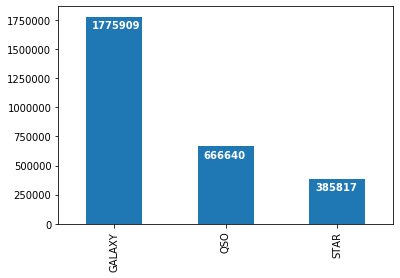

In [6]:
vc = df['class'].value_counts()

p = vc.plot.bar()

for i, v in enumerate(vc):
    p.text(y=v-100000,x=i-.20,s= str(v), color='white', fontweight='bold')


A first glance at the catalog reveals there are about 1.77 million galaxies, 666 thousand quasars and 385 thousand stars, for a ratio of approximately 6:2:1.

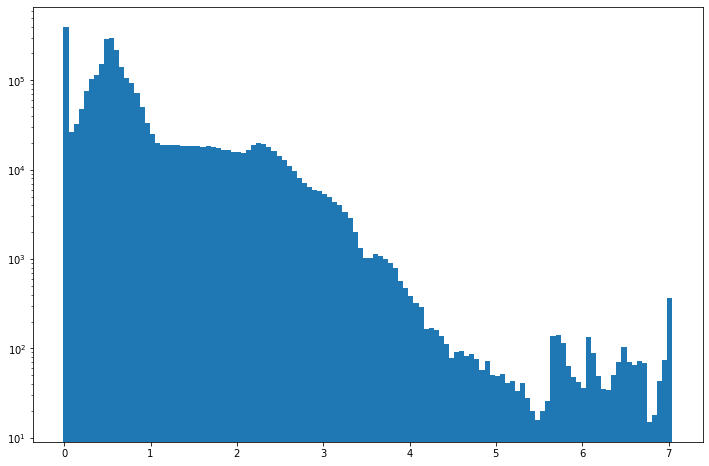

In [7]:
df['z'].hist(grid = False, bins = 120, figsize=(12,8))\
    .set_yscale('log')


Now we get to see why the partition for ```z``` was not uniform, because data distribution is very skewed to the left (note the log scale), also this shows a lot of the spectra have a negative value for z, being this the reason for the very small upper limit in the first range.

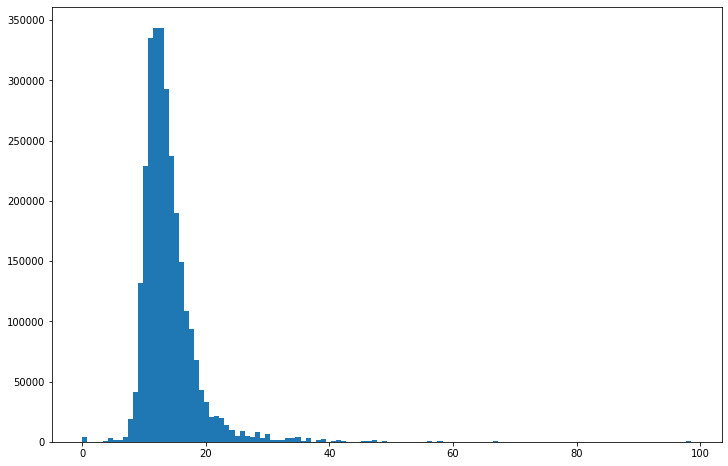

In [8]:
df['deredSN2'].hist(grid = False, bins = 120, figsize=(12,8))

Up to this point, we've only obtained the spectra catalog, but the actual spectra is a much bigger dataset weighting about 220kb for each spectra (almost 600GiB for the whole 2.8 million observations). For our usecase, we don't have the computing power, nor the storage, to work with such dataset.

For this reason, we're going to work with a tiny fraction of it, made of about 110000 spectra (totalling a much more manageable 22GiB). As our main class of interest is Quasars, we're going to choose our sample with a ratio of 5:4:2, to be sure quasars are well represented without altering too much the real world proportion. For our sample, we're going to use the cleanest available spectra, and the plot above shows that most of the entries have a very good Signal to Noise ratio (i.e. less than 20%) which is expected because the used view only contains the best observations from the SDSS dataset.

Since we're going to perform classification, we're going to see if this trend is mantained for each class.

3% of Galaxies have a SNR2 bellow 8.99


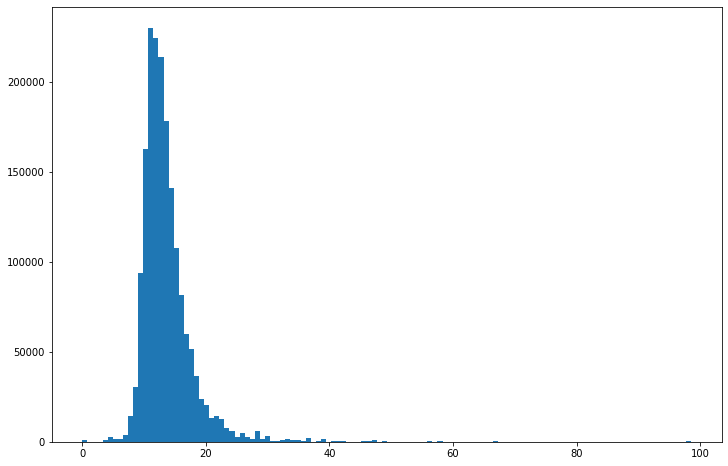

In [9]:
df[df['class']=='GALAXY']['deredSN2'].hist(grid = False, bins = 120, figsize=(12,8))

print('3% of Galaxies have a SNR2 bellow {:.3}'\
      .format(df[df['class']=='GALAXY']['deredSN2'].quantile(0.03)))

4% of Quasars have a SNR2 bellow 9.72


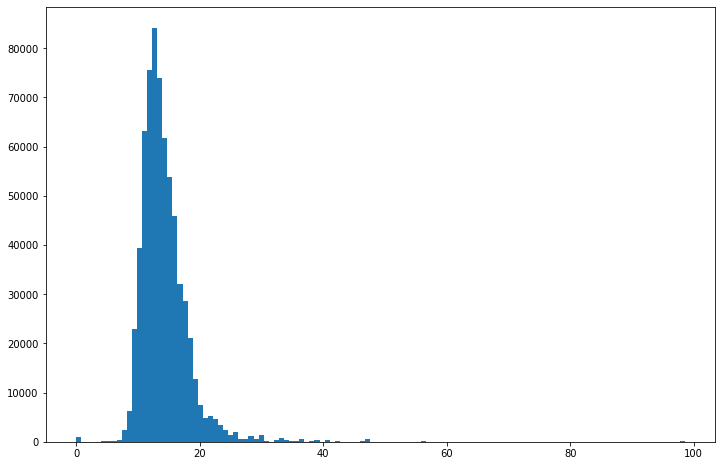

In [10]:
df[df['class']=='QSO']['deredSN2'].hist(grid = False, bins = 120, figsize=(12,8))

print('4% of Quasars have a SNR2 bellow {:.3}'\
      .format(df[df['class']=='QSO']['deredSN2'].quantile(0.04)))

4% of Stars have a SNR2 bellow 9.53


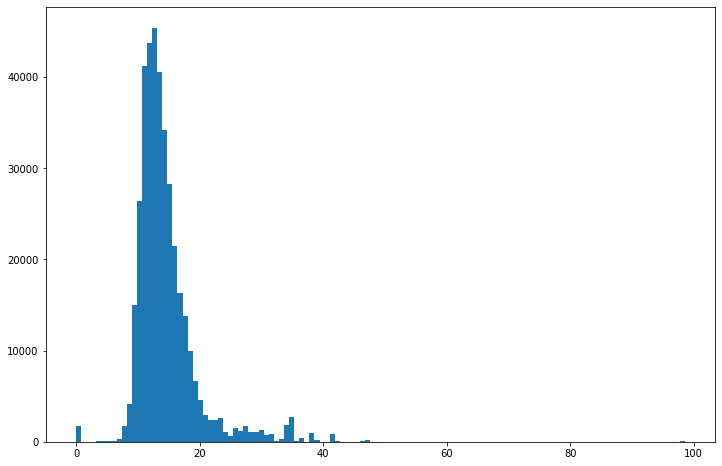

In [11]:
df[df['class']=='STAR']['deredSN2'].hist(grid = False, bins = 120, figsize=(12,8))

print('4% of Stars have a SNR2 bellow {:.3}'\
      .format(df[df['class']=='STAR']['deredSN2'].quantile(0.04)))

This shows that for all the classes the trend holds, and that we can reach our target sample size by using only entries with ```deredSN2``` below 9% for galaxies and 10% for quasars and stars. But we also want to make sure the ```ra```, ```dec``` and ```z``` spaces are well represented in this sample.

In [12]:
GALAXYS = df[df['class']=='GALAXY']
QSOS = df[df['class']=='QSO']
STARS = df[df['class']=='STAR']

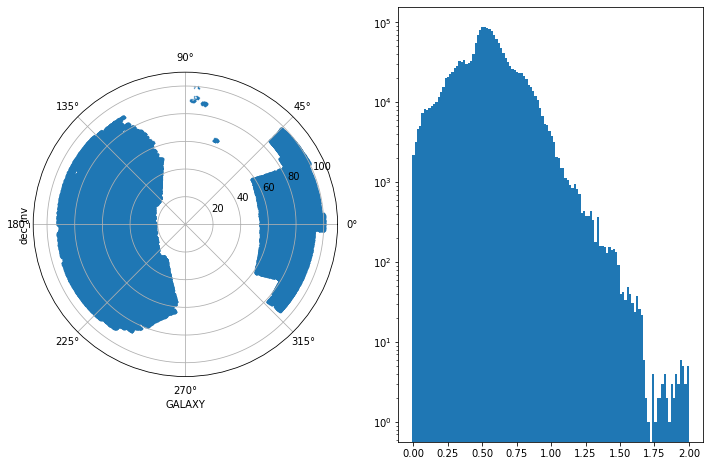

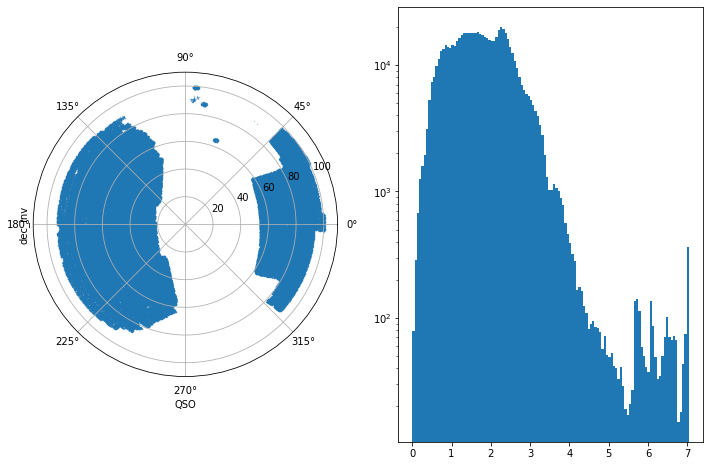

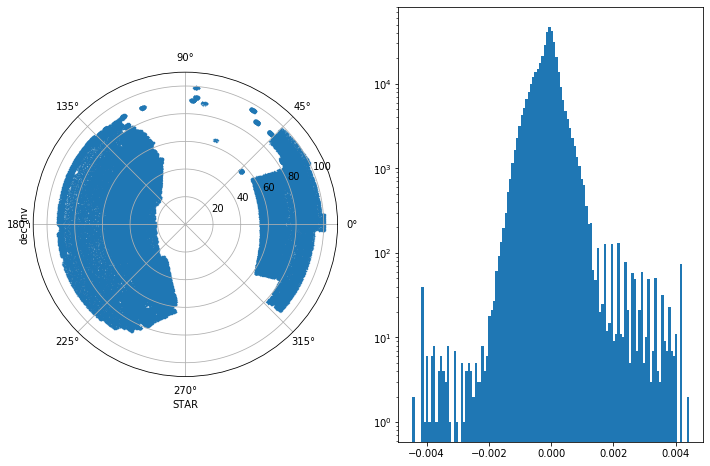

In [13]:
# Loop through groups
for sub_df in [[GALAXYS,0.03],[QSOS,0.04],[STARS,0.04]]:
    sub_df_sample = sub_df[0].copy()
    sub_df_sample['dec_inv'] = 90- sub_df_sample['dec']
    sub_df_sample['ra_rad'] = sub_df_sample['ra']*2*np.pi/360
    
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='polar')
    ax.set_ylim(top = 110)
    
    sub_df_sample.plot.scatter('ra_rad', 'dec_inv', s=0.05,  alpha=0.75,ax=ax,grid=True)\
        .set_xlabel(sub_df_sample['class'].iloc[0])
        
    ax = fig.add_subplot(122)
    sub_df_sample['z'].hist(grid = False, bins = 120, figsize=(12,8),ax=ax)
    ax.set_yscale('log')

We can see the distribution off all kinds of objects is not uniform across all the sky. The region of the sky that isn't observed in the dataset corresponds to the Milky Way, and this happens because it obstructs our view, so as the targets of the survey lie beyond our galaxy they can only be visible in other directions. Outside this region, the distribution appears to be uniform.

Also, we can see that the distribution for ```z``` varies a lot between classes, being very small for stars, varying from 0 to 2 for galaxies and going up to 7 for quasars.

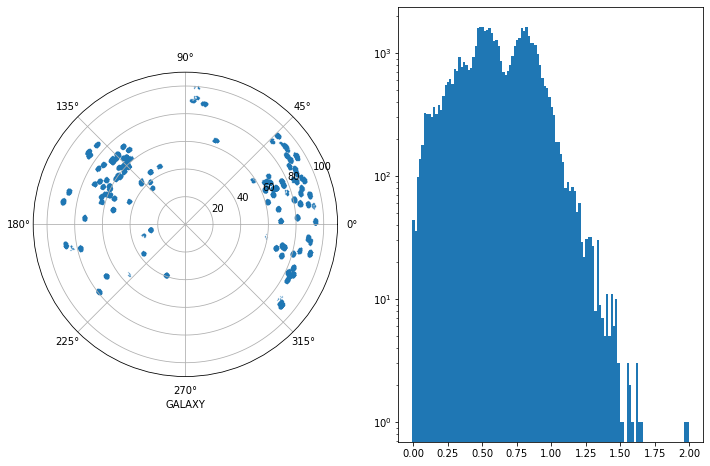

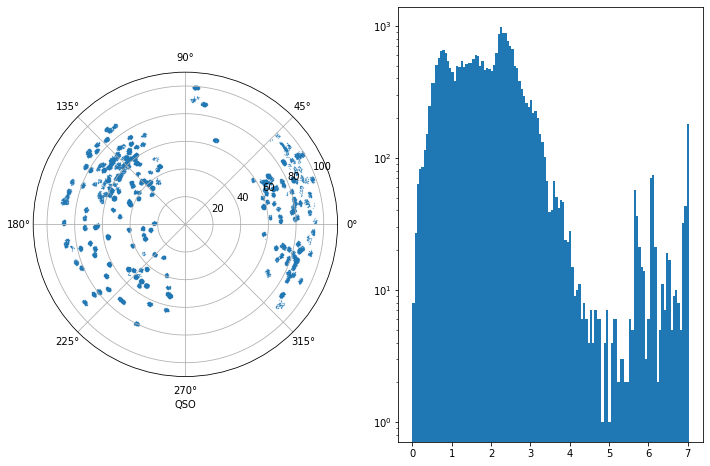

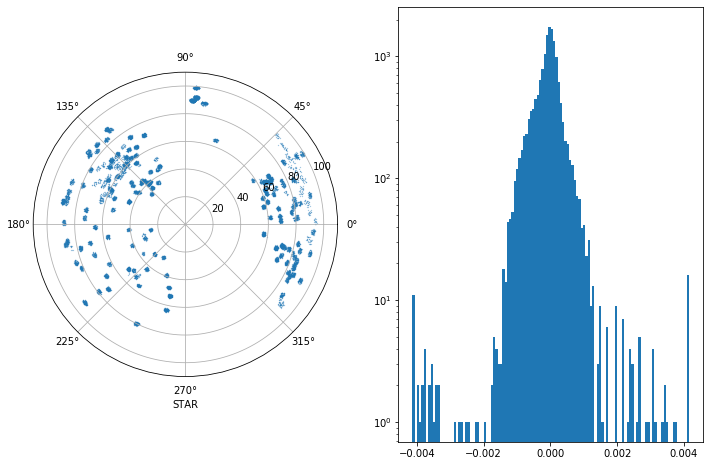

In [14]:
# Loop through groups
for sub_df in [[GALAXYS,0.03],[QSOS,0.04],[STARS,0.04]]:
    threshold = sub_df[0]['deredSN2'].quantile(sub_df[1])
    sub_df_sample = sub_df[0][sub_df[0]['deredSN2']<threshold].copy()
    sub_df_sample['dec_inv'] = 90- sub_df_sample['dec']
    sub_df_sample['ra_rad'] = sub_df_sample['ra']*2*np.pi/360
    
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='polar')
    
    sub_df_sample.plot.scatter('ra_rad', 'dec_inv', s=0.05,  alpha=0.75,ax=ax,grid=True)
    
    ax.set_ylim(top = 110)
    ax.set_xlabel(sub_df_sample['class'].iloc[0])
    ax.set_ylabel("")
    
    ax = fig.add_subplot(122)
    sub_df_sample['z'].hist(grid = False, bins = 120, figsize=(12,8),ax=ax)
    ax.set_yscale('log')

The plots above show that the distribution for ```z``` is kept pretty well in our sample, while the distribution of locations has clusters. This is probably because ```SNR2``` has the same value for all specra from a plate observed in a given date, this means that most of the best 110000 spectra probably come from the best 200 to 400 ```(plate, mjd)``` combinations, this results in a clustered sample, with a cluster corresponding to each of this best plates and most of these having 250 to 500 spectra belonging to it.

In [15]:
threshold_gal = GALAXYS['deredSN2'].quantile(0.03)
GALAXYS_TO_KEEP = GALAXYS[GALAXYS['deredSN2']<=threshold_gal]


threshold_qso = QSOS['deredSN2'].quantile(0.06)
QSOS_TO_KEEP = QSOS[QSOS['deredSN2']<=threshold_qso]


threshold_stars = STARS['deredSN2'].quantile(0.05)
STARS_TO_KEEP = STARS[STARS['deredSN2']<=threshold_stars]

In [16]:
dfk = pd.concat([GALAXYS_TO_KEEP,QSOS_TO_KEEP,STARS_TO_KEEP])
dfk

,specobjid,ra,dec,class,z,plate,mjd,fiberid,deredSN2
38823,4593686278508400640,323.069100,2.870847,GALAXY,0.000055,4080,55368,53,7.09296
66831,5107298404616392704,3.777792,10.267127,GALAXY,-0.000139,4536,55857,787,8.81285
74725,5252354505673297920,22.623240,13.499939,GALAXY,-0.000275,4665,56209,114,8.87815
75708,5248091689109966848,25.624720,13.986727,GALAXY,0.002454,4661,55614,990,7.92399
76042,5251345703368937472,16.406497,13.348471,GALAXY,-0.000232,4664,56186,540,8.12728
...,...,...,...,...,...,...,...,...,...
386940,10814504861376466944,132.097970,26.822619,STAR,0.000453,9605,58108,859,7.04657
386941,10814528225998557184,132.673570,27.103818,STAR,-0.000357,9605,58108,944,7.04657
386942,10814535097946230784,132.840980,26.473839,STAR,-0.000447,9605,58108,969,7.04657
387249,10807524612193406976,134.169240,23.201618,STAR,0.000087,9599,58131,41,5.49435


Total clusters: 378


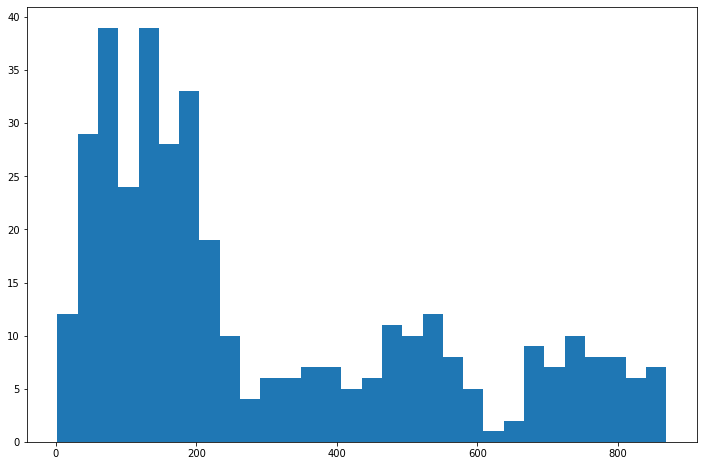

In [17]:
print('Total clusters: {}'.format(dfk['plate'].value_counts().size))

dfk['plate'].value_counts()\
    .hist(grid = False, bins = 30, figsize=(12,8))

This shows that the hypothesis about clustering relation to plates is most likely true, with many plates of over 500 entries and a a big majority having more than 100. In total, the 112.000 chosen spectra come from only 378 plates, each of which creates a cluster of observations.

## Spectra download

Each spectra is stored in a FITS file in the SDSS servers, and is downloadable from a service called SAS. We generated the download url for each file and stored it in a text file, which was passed as input to ```wget``` to perform a batch download.

In [18]:
dfk.apply(lambda x:
         'https://data.sdss.org/sas/dr16/eboss/spectro/redux/v5_13_0/spectra/lite/{}/spec-{}-{}-{:04d}.fits'\
         .format(x['plate'],x['plate'],x['mjd'],x['fiberid']),axis=1)\
         .to_csv("data_to_download.csv", sep=',', header=False,index=False)

As we are going to join the catalog to the spectra data later, and we're going to use the corresponding file name as key, we change the index.

In [19]:
dfk.index=dfk.apply(lambda x:
         'spec-{}-{}-{:04d}.fits'\
         .format(x['plate'],x['mjd'],x['fiberid']),axis=1)

## FITS files description

To read and process the FITS files, we used the ```astropy``` package, which has methods to generate a ```pandas``` DataFrame from the tables inside a FITS file.

In [5]:
import astropy.io.fits as pyfits

from astropy.table import QTable

Each FITS file is composed of 4 tables. The first one ```PRIMARY``` is proper of the FITS format, and is not used. The **second** one has most of the data, having always 8 columns and a varying amount of rows, this is the main piece of data we're going to use, containing the meassured light flux for each wavelenght, as well as the calculated portion of this flux corresponding to the sky and the observerd object respectively and the parameters of a fitted model (according to the ```'v5_13_0'``` algorithm). The third is a wide table with one row and 236 columns, this contains the same information available in the ```specObj``` table in the SQLServer, so as we already collected the information we need we're not going to use it. Finally, the last table contains a lighter summary of the spectra, for 32 wavelenght regions, since some of our classification strategies (like the CNN) takes advantage from greater detail, we preffered to use the more detailed information in the second table.

In [21]:
with pyfits.open('spec-3661-55212-0009.fits') as stdfile:
    print(stdfile.info())

Filename: spec-3661-55212-0009.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     119   ()      
  1                1 BinTableHDU     33   4624R x 8C   [E, E, E, J, J, E, E, E]   
  2                1 BinTableHDU    501   1R x 236C   [4A, 5A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 6A, D, D, 3A, A, E, E, E, J, E, 21A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, A, A, A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, A, E, 35E, 19A, A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E,

As noted before, the table we're going to use has a row for each wavelenght, and 8 columns:
* **FLUX:** Calculated amount of light comming from the observed object (instead of the athmosphere/sky) for this wavelength.
* **LOGLAM:** Base10 logarithm of the current wavelenght, each row has a ```0.0001``` increment respect to the previous one.
* **IVAR:** Inverse of the calculated variance of the measured flux respect to the best fit model, this can be understood as the confidence of the measurement, with $IVAR=0$ meaning no confidence at all (meaningless value) and $IVAR\rightarrow\infty$ being almost certain.
* **AND_MASK:** The measured spectra is the result of 3 observations, this bitmask stores warning flags that where pressent for the current wavelength in ALL of the observations.
* **OR_MASK:** The measured spectra is the result of 3 observations, this bitmask stores warning flags that where pressent for the current wavelength in ANY of the observations.
* **WDISP:** The fitting model uses a wavelenght dispersion parameter to weight the influence a given measured wavelenght has on its neighbours best-fit model.
* **SKY:** Calculated amount of light comming from the athmosphere/sky (instead of the observed object) for this wavelength.
* **MODEL:** Expected flux from the object according to the best fit model.

In [22]:
with pyfits.open('spec-3661-55212-0009.fits') as stdfile:
    print(stdfile[1].columns)

ColDefs(
    name = 'FLUX'; format = 'E'
    name = 'LOGLAM'; format = 'E'
    name = 'IVAR'; format = 'E'
    name = 'AND_MASK'; format = 'J'
    name = 'OR_MASK'; format = 'J'
    name = 'WDISP'; format = 'E'
    name = 'SKY'; format = 'E'
    name = 'MODEL'; format = 'E'
)


## Joining the downloaded files into a single dataset

A total of 112.683 files were successfully downloaded, but having that many separated files make the exploratory data analysis and in general data transformations very time consuming. Also, the FITS files contain header information that repeats for each file and increases disk space, and some other information about the spectra that we're not going to use in our classification problem. For this reason we desided to join them in a single dataframe with a row for each observation, doing this in a file per file basis and then concatenating them in a single operation proved to be an expensive and RAM heavy process beyond the server capacity, so the data was fractioned in 113 buckets, each with 1.000 files (683 for the first one).

In [23]:
data_dir = 'data/fits/'
out_dir = 'n_data/'
file_names = listdir(data_dir)
last_bucket = math.ceil(len(file_names)/1000) - 1

for done in range(len(file_names)):
    sect = str(last_bucket -math.floor(done/1000)) + '/'
    if not path.exists(out_dir + sect):
        mkdir(out_dir + sect)
    filename = file_names[done]
    if filename.endswith('.fits'):
        move(data_dir+filename, out_dir+sect+filename)

For each of the resulting folders a single DataFrame was created with the same format of the table in the FITS file, with an extra column for the file name. The resulting dataframe list was dumped in separate ```joblib``` files.

In [55]:
def fitsToPd (file_name):
    with pyfits.open(file_name) as stdfile:
        return QTable(stdfile[1].data).to_pandas()

In [56]:
def ProcessFiles (subdir):
    df_thread=[]
    file_names = listdir(subdir)
    
    return pd.concat((fitsToPd(path.join(subdir,file_name)).\
               assign(FileName=file_name)
               for file_name in file_names))\
            .query('LOGLAM>=3.5600 & LOGLAM <= 4.0000')\
            .pivot(index='FileName',columns='LOGLAM')
    

In [48]:
temp_df = ProcessFiles('n_data/0')

In [51]:
temp_df2 = temp_df[temp_df['LOGLAM'].between(3.5600,4.0000)]
temp_df2

,FLUX,LOGLAM,IVAR,AND_MASK,OR_MASK,WDISP,SKY,MODEL,FileName
30,0.682317,3.5600,0.073310,0,0,1.131172,19.526989,0.436442,spec-7159-56603-0896.fits
31,0.934502,3.5601,0.073618,0,0,1.130442,19.921093,0.428208,spec-7159-56603-0896.fits
32,1.359440,3.5602,0.073567,0,0,1.130351,19.723356,0.424040,spec-7159-56603-0896.fits
33,1.403693,3.5603,0.072724,0,0,1.134212,19.911774,0.425453,spec-7159-56603-0896.fits
34,-0.941495,3.5604,0.076891,0,0,1.135525,20.283125,0.431313,spec-7159-56603-0896.fits
...,...,...,...,...,...,...,...,...,...
4483,4.836654,3.9996,0.494561,0,0,0.849797,3.708430,3.833961,spec-7150-56597-0296.fits
4484,4.760417,3.9997,0.567779,0,0,0.850032,4.100183,3.853665,spec-7150-56597-0296.fits
4485,7.131167,3.9998,0.502178,0,0,0.850263,6.100383,3.756140,spec-7150-56597-0296.fits
4486,5.409600,3.9999,0.236993,0,0,0.850500,10.584570,3.814742,spec-7150-56597-0296.fits


In [53]:
temp_df3 = temp_df.query('LOGLAM>=3.5600 & LOGLAM <= 4.0000')
temp_df3

,FLUX,LOGLAM,IVAR,AND_MASK,OR_MASK,WDISP,SKY,MODEL,FileName
30,0.682317,3.5600,0.073310,0,0,1.131172,19.526989,0.436442,spec-7159-56603-0896.fits
31,0.934502,3.5601,0.073618,0,0,1.130442,19.921093,0.428208,spec-7159-56603-0896.fits
32,1.359440,3.5602,0.073567,0,0,1.130351,19.723356,0.424040,spec-7159-56603-0896.fits
33,1.403693,3.5603,0.072724,0,0,1.134212,19.911774,0.425453,spec-7159-56603-0896.fits
34,-0.941495,3.5604,0.076891,0,0,1.135525,20.283125,0.431313,spec-7159-56603-0896.fits
...,...,...,...,...,...,...,...,...,...
4483,4.836654,3.9996,0.494561,0,0,0.849797,3.708430,3.833961,spec-7150-56597-0296.fits
4484,4.760417,3.9997,0.567779,0,0,0.850032,4.100183,3.853665,spec-7150-56597-0296.fits
4485,7.131167,3.9998,0.502178,0,0,0.850263,6.100383,3.756140,spec-7150-56597-0296.fits
4486,5.409600,3.9999,0.236993,0,0,0.850500,10.584570,3.814742,spec-7150-56597-0296.fits


In [54]:
temp_df3.pivot(index='FileName',columns='LOGLAM')

FLUX                                  \
LOGLAM                        3.5600     3.5601     3.5602    3.5603   
FileName                                                               
spec-6734-56386-0302.fits  -1.209955   0.982066   3.811422  2.739377   
spec-6734-56386-0304.fits  -0.813648   3.350289  -0.166975  0.911030   
spec-6734-56386-0306.fits   3.594176   1.930587   1.935376  0.731304   
spec-6734-56386-0310.fits  11.047215  13.538736  11.991402  4.603322   
spec-6734-56386-0312.fits  -0.607426   1.922080   3.475278 -1.312162   
...                              ...        ...        ...       ...   
spec-9211-57722-0244.fits  11.296166   0.689204  -3.240561  8.043983   
spec-9211-57722-0245.fits  -4.351378  -4.803648   0.444673 -0.511090   
spec-9211-57722-0246.fits   8.334728   1.043101  -7.184809  9.576024   
spec-9211-57722-0248.fits  -9.946617  -3.544755   5.755305 -6.178302   
spec-9211-57722-0251.fits  -1.291734   2.175200   0.590739  2.657490   

                                                                               \
LOGLAM                       3.5604    3.5605    3.5606     3.5607     3.5608   
FileName                                                                        
spec-6734-56386-0302.fits  3.868890  6.495961  7.253661   6.409298  -1.515369   
spec-6734-56386-0304.fits  1.045437 -1.842884  0.835884   2.971167   2.757457   
spec-6734-56386-0306.fits -2.058289  0.553903 -2.394800   0.039044   1.105941   
spec-6734-56386-0310.fits  6.302942  4.292010  7.249594  10.643600  10.040031   
spec-6734-56386-0312.fits  4.670000  1.940645  1.726271   1.181178  -0.841530   
...                             ...       ...       ...        ...        ...   
spec-9211-57722-0244.fits -4.697714 -2.154494  0.636923  -0.276718   2.163903   
spec-9211-57722-0245.fits -4.549429 -3.203662  5.668605  10.691048   1.326386   
spec-9211-57722-0246.fits  2.579128 -7.231847  2.971809   8.710176  -8.688537   
spec-9211-57722-0248.fits  5.071044 -2.924076 -4.739834  -2.127175  -5.621857   
spec-9211-57722-0251.fits -1.569939  5.151239  5.035505   1.437809   6.290987   

                                     ...     MODEL                      \
LOGLAM                       3.5609  ...    3.9991    3.9992    3.9993   
FileName                             ...                                 
spec-6734-56386-0302.fits  3.452069  ...  1.533038  1.508910  1.500512   
spec-6734-56386-0304.fits -0.269313  ...  0.823536  0.822659  0.821769   
spec-6734-56386-0306.fits  2.184348  ...  0.655480  0.651079  0.644601   
spec-6734-56386-0310.fits  7.484833  ...  3.843178  3.841777  3.840770   
spec-6734-56386-0312.fits  1.054815  ...  0.756443  0.774905  0.772471   
...                             ...  ...       ...       ...       ...   
spec-9211-57722-0244.fits  1.783122  ...  1.549519  0.838081  0.568039   
spec-9211-57722-0245.fits -7.343309  ...  0.272350  0.274634  0.278179   
spec-9211-57722-0246.fits  1.849597  ...  0.303017  0.300725  0.307880   
spec-9211-57722-0248.fits  2.968010  ...  0.308549  0.295505  0.280441   
spec-9211-57722-0251.fits  1.456009  ...  0.306476  0.325273  0.285088   

                                                                             \
LOGLAM                       3.9994    3.9995    3.9996    3.9997    3.9998   
FileName                                                                      
spec-6734-56386-0302.fits  1.507977  1.502453  1.479302  1.475010  1.478605   
spec-6734-56386-0304.fits  0.820744  0.819189  0.817740  0.817418  0.816700   
spec-6734-56386-0306.fits  0.650050  0.649997  0.629961  0.624716  0.629094   
spec-6734-56386-0310.fits  3.838775  3.834307  3.830591  3.828325  3.826589   
spec-6734-56386-0312.fits  0.758511  0.759239  0.760787  0.742778  0.735952   
...                             ...       ...       ...       ...       ...   
spec-9211-57722-0244.fits  0.451018  0.409961  0.384542  0.356472  0.363786   
spec-9211-57722-0245.fits  0.274000  0.262124  0.247940  0.23

683

In [59]:
data_dir = 'n_data/'
subdirs = listdir(data_dir)

for subdir in subdirs:
    joblib.dump(
        ProcessFiles(path.join(data_dir,subdir)),
        "data/{}.joblib".format(subdir)
    )

The process was repeated to create 4 dataframes with 30.000 spectra each (22.683 for the last one), these in turn where joined in pairs (resulting in two DFs one with 60.000 spectra and the other with 52.683) and these where subsequently joined in a single final Data Frame. The reason this was needed (having enough memory to fit the final dataset three times) is not clear, but probably is due to implementation details of the pandas library that make the ```concat()``` method with an iterable of DataFrames as input very memory hungry.

In [58]:
for i in range(4):
    inf = i*30
    sup = min((i+1)*30,113)
    joblib.dump(
        pd.concat(
            (joblib.load('data/{}.joblib'.format(j)) for j in range(inf,sup))
        ),
        'data/{}-{}.joblib'.format(inf,sup)
    )

FileNotFoundError: [Errno 2] No such file or directory: 'data/0.joblib'

In [60]:
joblib.dump(
    pd.concat(
        (joblib.load('data/{}.joblib'.format(j)) for j in range(113))
    ),
    'data/full_dataset.joblib'.format(inf,sup)
)

['data/full_dataset.joblib']

In [28]:
joblib.dump(
    pd.concat(
        (joblib.load('data/{}-{}.joblib'.format(i,s)) for i,s in [(0,30),(30,60)])
    ),
    'data/H1.joblib'
)

joblib.dump(
    pd.concat(
        (joblib.load('data/{}-{}.joblib'.format(i,s)) for i,s in [(60,90),(90,113)])
    ),
    'data/H2.joblib'
)

joblib.dump(
    pd.concat(
        (joblib.load('data/{}.joblib'.format(h)) for h in ['H1','H2'])
    ),
    'data/full_dataset.joblib'
)

['data/full_dataset.joblib']

## Determining optimal range for wavelenght

Although the step between ```LOGLAM``` values is fixed in all files, and there are complete ranges for each observation, this range varies from one observation to the other. If we attempt to pivot the table as is, without first filtering for an optimal range of wavelenghts, a single outlier with a too high or too low value for ```LOGLAM```  will hugely increase the amount of columns for the whole dataset, most of which would be filled with ```NaN``` anyway. This would innecesarily increase the memory requirements for the dataset, the storage space, the complexity of the classification algorithms to use, and all this without a foreseeable improvement for the generated model.

For this reason, we'll look at the distribution of the start and end of the range for all files to determine an optimal range that is completely present in most of the observations.

In [3]:
df_spec = joblib.load('data/small.joblib')
df_spec

,FLUX_3.5600,FLUX_3.5601,FLUX_3.5602,FLUX_3.5603,FLUX_3.5604,FLUX_3.5605,FLUX_3.5606,FLUX_3.5607,FLUX_3.5608,FLUX_3.5609,...,MODEL_3.9999,MODEL_4.0000,ra,dec,class,z,plate,mjd,fiberid,deredSN2
specobjid,,,,,,,,,,,,,,,,,,,,,
4862885485104877568,-4.106949,1.621307,3.588695,-5.471988,5.618440,-5.042220,3.144175,3.283159,0.578459,4.093633,...,7.091682,7.105092,333.948550,3.207086,GALAXY,0.212692,4319,55507,450,8.204860
5107126056168738816,0.016765,-0.314855,0.127769,-1.319999,-1.402305,1.678479,0.460242,-0.615950,1.122983,-3.331632,...,2.623328,2.614779,3.989317,9.032212,GALAXY,0.433842,4536,55857,160,8.812850
5834526398463889408,0.222169,5.310606,2.399057,1.397279,1.680085,-0.225869,0.546743,-2.875223,-2.782421,-2.823659,...,1.352418,1.342956,133.146990,28.504441,GALAXY,0.625188,5182,56341,411,8.129610
5832406533435314176,3.367295,-1.264974,-0.114611,9.314883,12.866903,0.225988,-7.216692,-3.300864,7.599996,12.078270,...,2.903243,2.903063,132.036660,25.759779,GALAXY,0.575761,5180,55947,891,8.692960
4946340898885881856,-1.677028,-0.517481,7.995548,3.185259,-1.550870,-0.289748,-3.798154,-5.539924,4.642006,0.468494,...,1.874680,1.882415,32.872676,-3.339453,GALAXY,0.574863,4393,55944,955,8.894700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8173159322714656768,1.666548,-7.187265,0.295226,-2.787717,-0.490583,0.353539,2.032229,4.527013,1.058172,1.403409,...,8.278163,8.285258,85.696793,-1.146560,STAR,0.000157,7259,56603,916,0.000000
4951973422110625792,-3.984480,1.477212,4.929414,5.950519,3.726045,2.132871,7.782515,0.113680,2.419172,4.295060,...,0.134918,0.136324,32.453205,-5.757612,STAR,-0.000449,4398,55946,966,9.577540
8222712119633924096,1.784547,9.231626,5.131457,4.778953,-1.203799,-0.940644,-0.222141,-5.431338,5.649516,-1.334066,...,4.368240,4.393759,134.015790,50.682343,STAR,-0.000128,7303,57013,964,9.151740


In [17]:
len(df_spec)

5634

In [15]:
df_spec.iloc[:1000,:-8]

,FLUX_3.5600,FLUX_3.5601,FLUX_3.5602,FLUX_3.5603,FLUX_3.5604,FLUX_3.5605,FLUX_3.5606,FLUX_3.5607,FLUX_3.5608,FLUX_3.5609,...,MODEL_3.9991,MODEL_3.9992,MODEL_3.9993,MODEL_3.9994,MODEL_3.9995,MODEL_3.9996,MODEL_3.9997,MODEL_3.9998,MODEL_3.9999,MODEL_4.0000
specobjid,,,,,,,,,,,,,,,,,,,,,
4862885485104877568,-4.106949,1.621307,3.588695,-5.471988,5.618440,-5.042220,3.144175,3.283159,0.578459,4.093633,...,7.072595,7.075722,7.070400,7.061088,7.059958,7.062634,7.069207,7.079515,7.091682,7.105092
5107126056168738816,0.016765,-0.314855,0.127769,-1.319999,-1.402305,1.678479,0.460242,-0.615950,1.122983,-3.331632,...,2.617152,2.621761,2.626300,2.630238,2.632448,2.633271,2.632402,2.629045,2.623328,2.614779
5834526398463889408,0.222169,5.310606,2.399057,1.397279,1.680085,-0.225869,0.546743,-2.875223,-2.782421,-2.823659,...,1.319812,1.324851,1.337660,1.345835,1.350044,1.355569,1.355957,1.357679,1.352418,1.342956
5832406533435314176,3.367295,-1.264974,-0.114611,9.314883,12.866903,0.225988,-7.216692,-3.300864,7.599996,12.078270,...,2.921308,2.913859,2.916060,2.912908,2.900927,2.906333,2.901644,2.903035,2.903243,2.903063
4946340898885881856,-1.677028,-0.517481,7.995548,3.185259,-1.550870,-0.289748,-3.798154,-5.539924,4.642006,0.468494,...,1.881317,1.871299,1.868252,1.869860,1.863119,1.867231,1.862921,1.868890,1.874680,1.882415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10830263332843573248,7.826623,6.877193,3.917549,-5.145656,8.214178,11.966593,-0.014891,-6.029862,2.550684,-9.254128,...,0.364997,0.365593,0.365710,0.370476,0.372379,0.371410,0.361878,0.345136,0.345623,0.360408
7043781655895756800,6.086950,0.880411,1.938327,7.439972,5.784932,4.183224,6.346933,8.766102,7.783952,7.341353,...,16.112165,16.068558,16.028851,16.006582,16.011538,16.038900,16.070444,16.088800,16.085798,16.063240
4946271079897518080,6.408720,-9.904831,-1.335285,-0.383151,-1.046172,-2.244667,-0.856951,13.911798,6.465325,-0.232616,...,1.720476,1.728047,1.732267,1.736155,1.736705,1.733190,1.725535,1.718826,1.719527,1.711816


In [33]:
df_spec.iloc[:1000,-6].values.codes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
expansion = np.eye(3)
expansion[:, df_spec.iloc[:,-6].values.codes].T

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [16]:
df_spec.iloc[:1000,:-8].values.reshape(1000,4401,7)

array([[[-4.10694933,  1.62130725,  3.58869457, ...,  5.61844015,
         -5.04222012,  3.14417529],
        [ 3.28315926,  0.57845896,  4.0936327 , ...,  1.78199637,
          2.92826414,  4.78923607],
        [ 2.98521447, -1.26577067,  0.65584618, ..., -2.8010273 ,
         -2.9857161 ,  2.67449665],
        ...,
        [ 7.01295614,  7.0120039 ,  6.99084377, ...,  6.96520042,
          6.96682167,  6.97394323],
        [ 6.98489714,  7.0068121 ,  7.03628397, ...,  7.07259464,
          7.07572174,  7.07040024],
        [ 7.06108761,  7.05995846,  7.06263399, ...,  7.0795145 ,
          7.09168196,  7.10509157]],

       [[ 0.01676459, -0.31485516,  0.12776929, ..., -1.40230477,
          1.67847908,  0.46024171],
        [-0.61594981,  1.1229831 , -3.33163238, ...,  1.84320676,
          1.1376456 , -0.76938266],
        [-1.98499012, -0.52746457, -0.05293174, ..., -0.59297979,
          0.09578298,  0.36602536],
        ...,
        [ 2.60893679,  2.60649085,  2.6028645 , ...,  

In [30]:
limits = pd.DataFrame()
limits['start'] = df_spec.groupby('FileName')['LOGLAM'].min()
limits['end'] = df_spec.groupby('FileName')['LOGLAM'].max()
limits.index = df_spec.groupby('FileName')['FileName'].first()

In [31]:
limits = limits.join(dfk)
limits

,start,end,specobjid,ra,dec,class,z,plate,mjd,fiberid,deredSN2
FileName,,,,,,,,,,,
spec-10000-58141-0023.fits,3.5552,4.0140,11259005527202746368,30.994859,26.620342,STAR,-0.000066,10000,58141,23,9.31163
spec-10000-58141-0024.fits,3.5552,4.0139,11259005802080653312,30.954670,26.771762,QSO,1.391259,10000,58141,24,9.31163
spec-10000-58141-0032.fits,3.5551,4.0139,11259008001103908864,30.914241,27.077912,STAR,-0.000104,10000,58141,32,9.31163
spec-10000-58141-0048.fits,3.5552,4.0139,11259012399150419968,30.879429,26.368072,STAR,-0.000013,10000,58141,48,9.31163
spec-10000-58141-0051.fits,3.5551,4.0139,11259013223784140800,30.792022,26.365543,STAR,-0.000196,10000,58141,51,9.31163
...,...,...,...,...,...,...,...,...,...,...,...
spec-9626-57875-0928.fits,3.5582,4.0155,10838167722086649856,154.628680,26.457632,QSO,1.188501,9626,57875,928,9.85345
spec-9626-57875-0940.fits,3.5581,4.0155,10838171020621533184,154.668810,26.161670,QSO,1.388088,9626,57875,940,9.85345
spec-9626-57875-0950.fits,3.5582,4.0155,10838173769400602624,154.840050,26.790159,QSO,0.918330,9626,57875,950,9.85345


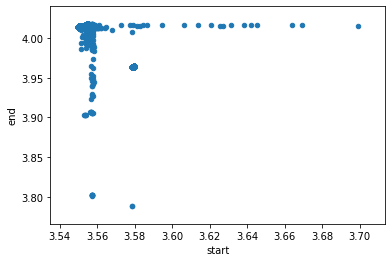

In [32]:
limits.plot.scatter(x='start',y='end')

In [33]:
((limits['start']>3.56005)|(limits['end']<3.99995)).sum()

986

This shows that most of the spectra (over 99%) in the sample has the whole range between ```3.560000``` and ```4.0000```. This range also contains the most important emission and absorption lines in astronomy, so we're going to use it as our wavelength range and filter out entries that are outside.

Done this, we can finally proceed to pivot the table by ```LOGLAM```, using ```FileName``` as index.

In [34]:
df_spec = df_spec[df_spec['LOGLAM'].between(3.5600,4.0000)]\
                .pivot(index='FileName',columns='LOGLAM')
df_spec

FLUX                                     \
LOGLAM                          3.5600      3.5601      3.5602     3.5603   
FileName                                                                    
spec-10000-58141-0023.fits  113.778854  106.634895  100.268417  96.380981   
spec-10000-58141-0024.fits   12.178663   -4.281895   -2.415574   3.293402   
spec-10000-58141-0032.fits   -4.337126   -6.652880    2.252219   0.963456   
spec-10000-58141-0048.fits   40.183010   33.649620   36.798435  41.571636   
spec-10000-58141-0051.fits   -2.148112   -5.689575    0.670504   1.657884   
...                                ...         ...         ...        ...   
spec-9626-57875-0928.fits    16.257719   22.574205   18.575493  21.601894   
spec-9626-57875-0940.fits     8.861087    4.548656   10.331887   7.681143   
spec-9626-57875-0950.fits    -1.615979    0.526454    3.784892   3.583715   
spec-9626-57875-0971.fits     9.038755   15.616426   15.793040  14.045360   
spec-9626-57875-0982.fits     6.416258    9.165004    5.780253   9.840270   

                                                                            \
LOGLAM                          3.5604      3.5605      3.5606      3.5607   
FileName                                                                     
spec-10000-58141-0023.fits  107.016441  115.956253  127.041557  115.037048   
spec-10000-58141-0024.fits    5.390670    5.254680    4.954724    6.772868   
spec-10000-58141-0032.fits   18.390308    8.048061    6.960538    2.805857   
spec-10000-58141-0048.fits   39.035606   35.062546   45.770164   52.602768   
spec-10000-58141-0051.fits    1.035314    0.700391    0.983966    1.626941   
...                                ...         ...         ...         ...   
spec-9626-57875-0928.fits    22.794037   17.259386   16.639582   16.776228   
spec-9626-57875-0940.fits    10.278730    9.500540    5.542446   10.603902   
spec-9626-57875-0950.fits     4.293525    1.179258   -0.431164    1.438223   
spec-9626-57875-0971.fits    17.151485   16.220976   15.340644   15.348165   
spec-9626-57875-0982.fits     6.329289    4.140832    5.799339    7.024320   

                                                    ...      MODEL             \
LOGLAM                          3.5608      3.5609  ...     3.9991     3.9992   
FileName                                            ...                         
spec-10000-58141-0023.fits  119.147881  129.313705  ...  49.877869  49.898838   
spec-10000-58141-0024.fits    3.650797   12.999368  ...   1.164093   1.147038   
spec-10000-58141-0032.fits   -5.222649   -1.492423  ...   0.464951   0.464482   
spec-10000-58141-0048.fits   44.064503   39.252113  ...  24.256678  24.261114   
spec-10000-58141-0051.fits    2.176358    1.796798  ...   1.174707   1.173413   
...                                ...         ...  ...        ...        ...   
spec-9626-57875-0928.fits    19.983366   17.459923  ...   3.653535   3.681997   
spec-9626-57875-0940.fits     7.857233    9.177867  ...   2.861222   2.874411   
spec-9626-57875-0950.fits     2.448325   -0.669492  ...   0.449257   0.437723   
spec-9626-57875-0971.fits    11.378103   11.615041  ...   3.031995   3.864178   
spec-9626-57875-0982.fits     6.055362    7.346190  ...   1.472341   1.502510   

                                                                        \
LOGLAM                         3.9993     3.9994     3.9995     3.9996   
FileName                                                                 
spec-10000-58141-0023.fits  49.871895  49.789738  49.720356  49.764523   
spec-10000-58141-0024.fits   1.158187   1.211497   1.187997   1.163981   
spec-10000-58141-0032.fits   0.463531   0.461865   0.460843   0.461088   
spec-10000-58141-0048.fits  24.254166  24.218561  24.180618  24.183964   
spec-10000-58141-0051.fits   1.167209   1.163388   1.168414   1.171800   
...                               ...        ...        ...        ...   
spec-9626-57875-0928.fits    3.602750   3.538500   3.614337  

## Joining catalog data and spectra

Now, ```df_spec``` and ```dfk``` (our spectra and catalog DataFrames) have the same index and number of rows, so we can join them in a single dataframe that will be the one and only source to train our models.

But before, we need to fix the last discrepancy between this two DFs, and it's their columns index, which is a two level multiindex for ```df_spec``` and a simple index for ```dfk```.

In [4]:
df_spec.columns = df_spec.columns.map(lambda x: x[0]+'_'+"{:.4f}".format(x[1]))
df_spec

,FLUX_3.5600,FLUX_3.5601,FLUX_3.5602,FLUX_3.5603,FLUX_3.5604,FLUX_3.5605,FLUX_3.5606,FLUX_3.5607,FLUX_3.5608,FLUX_3.5609,...,MODEL_3.9991,MODEL_3.9992,MODEL_3.9993,MODEL_3.9994,MODEL_3.9995,MODEL_3.9996,MODEL_3.9997,MODEL_3.9998,MODEL_3.9999,MODEL_4.0000
FileName,,,,,,,,,,,,,,,,,,,,,
spec-6734-56386-0302.fits,-1.209955,0.982066,3.811422,2.739377,3.868890,6.495961,7.253661,6.409298,-1.515369,3.452069,...,1.533038,1.508910,1.500512,1.507977,1.502453,1.479302,1.475010,1.478605,1.475068,1.474245
spec-6734-56386-0304.fits,-0.813648,3.350289,-0.166975,0.911030,1.045437,-1.842884,0.835884,2.971167,2.757457,-0.269313,...,0.823536,0.822659,0.821769,0.820744,0.819189,0.817740,0.817418,0.816700,0.815433,0.814392
spec-6734-56386-0306.fits,3.594176,1.930587,1.935376,0.731304,-2.058289,0.553903,-2.394800,0.039044,1.105941,2.184348,...,0.655480,0.651079,0.644601,0.650050,0.649997,0.629961,0.624716,0.629094,0.639588,0.635258
spec-6734-56386-0310.fits,11.047215,13.538736,11.991402,4.603322,6.302942,4.292010,7.249594,10.643600,10.040031,7.484833,...,3.843178,3.841777,3.840770,3.838775,3.834307,3.830591,3.828325,3.826589,3.824949,3.821860
spec-6734-56386-0312.fits,-0.607426,1.922080,3.475278,-1.312162,4.670000,1.940645,1.726271,1.181178,-0.841530,1.054815,...,0.756443,0.774905,0.772471,0.758511,0.759239,0.760787,0.742778,0.735952,0.745830,0.730441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spec-9610-58112-0980.fits,163.100464,150.555847,152.345474,154.227509,151.157730,156.135773,165.369751,144.974442,126.655754,120.526482,...,19.569109,19.875965,19.903484,19.687008,19.372906,19.368668,19.580584,19.193035,19.585875,19.732813
spec-9610-58112-0990.fits,8.196809,0.861799,0.278602,2.117417,5.403114,5.986683,2.143635,-0.322914,2.893570,-5.561350,...,0.324524,0.297084,0.262895,0.234664,0.248477,0.292927,0.293961,0.318313,0.315259,0.303994
spec-9610-58137-0008.fits,47.198105,0.329508,31.284245,47.440262,5.777784,-10.160325,38.188385,41.739941,4.608064,21.266136,...,10.500708,10.480878,10.487695,10.481406,10.463370,10.451114,10.468536,10.450230,10.399646,10.384990


In [9]:
df_spec

,FLUX_3.5600,FLUX_3.5601,FLUX_3.5602,FLUX_3.5603,FLUX_3.5604,FLUX_3.5605,FLUX_3.5606,FLUX_3.5607,FLUX_3.5608,FLUX_3.5609,...,MODEL_3.9999,MODEL_4.0000,ra,dec,class,z,plate,mjd,fiberid,deredSN2
specobjid,,,,,,,,,,,,,,,,,,,,,
7581893092946759680,-1.209955,0.982066,3.811422,2.739377,3.868890,6.495961,7.253661,6.409298,-1.515369,3.452069,...,1.475068,1.474245,228.41926,46.891521,QSO,2.874168,6734,56386,302,9.37717
7581893642702573568,-0.813648,3.350289,-0.166975,0.911030,1.045437,-1.842884,0.835884,2.971167,2.757457,-0.269313,...,0.815433,0.814392,228.37279,46.898251,STAR,-0.000991,6734,56386,304,9.37717
7581894192458387456,3.594176,1.930587,1.935376,0.731304,-2.058289,0.553903,-2.394800,0.039044,1.105941,2.184348,...,0.639588,0.635258,228.55150,47.018849,QSO,2.349198,6734,56386,306,9.37717
7581895291970015232,11.047215,13.538736,11.991402,4.603322,6.302942,4.292010,7.249594,10.643600,10.040031,7.484833,...,3.824949,3.821860,228.68061,47.211997,STAR,-0.000478,6734,56386,310,9.37717
7581895841725829120,-0.607426,1.922080,3.475278,-1.312162,4.670000,1.940645,1.726271,1.181178,-0.841530,1.054815,...,0.745830,0.730441,228.41153,46.866888,QSO,2.344070,6734,56386,312,9.37717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10820167621204529152,163.100464,150.555847,152.345474,154.227509,151.157730,156.135773,165.369751,144.974442,126.655754,120.526482,...,19.585875,19.732813,133.34547,28.686111,QSO,2.091138,9610,58112,980,4.44095
10820170369983598592,8.196809,0.861799,0.278602,2.117417,5.403114,5.986683,2.143635,-0.322914,2.893570,-5.561350,...,0.315259,0.303994,133.77400,28.169679,GALAXY,0.902416,9610,58112,990,4.44095
10819900440298409984,47.198105,0.329508,31.284245,47.440262,5.777784,-10.160325,38.188385,41.739941,4.608064,21.266136,...,10.399646,10.384990,133.92008,27.434813,STAR,0.000131,9610,58137,8,9.15596


Done this, finally we can join the two DataFrames, transform the ```class``` column from string to category, change the index from the filename to the ```SpecObjID``` (if we need to trace any row back to its file we can always compute its filename from ```plate```, ```mjd``` and ```fiberid```) and dump the result in a joblib file that can be loaded by any training program.

In [5]:
dfk = joblib.load('data/dfk.joblib')


In [11]:
df_spec = df_spec.join(dfk)

In [9]:
dfk['class'] = dfk['class'].astype('category')

In [12]:
df_spec.index = df_spec.specobjid

In [4]:
df_spec = df_spec.drop(columns='specobjid')

In [5]:
joblib.dump(df_spec, 'data/final_dataset.joblib')

['data/final_dataset.joblib']

## Creating reduced datasets for experimentation

Finaly, given the huge size of the complete dataset, it's reasonable to export also a small (5%) and a medium (20%) dataset for use during experimentation, leaving the full dataset to be used only in the end when the model training code has been tested with the smaller datasets.

In [6]:
from random import sample 

In [7]:
def export_subset (df, filename, frac):
    joblib.dump(
        pd.concat(
            (df[df_spec['class']==x].sample(frac=frac) 
             for x in ['GALAXY','QSO','STAR'])
            )
        ,filename
        )

In [8]:
export_subset(df_spec, 'data/small.joblib', 0.05)
export_subset(df_spec, 'data/medium.joblib', 0.20)